## Neural Network Approach for Seasonal Items Forecasting of a Retail Store
## Convolutional Neural Network (CNN)

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series


from tensorflow.keras.layers import Flatten, TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

import os
from tensorflow import set_random_seed
from numpy.random import seed

import warnings
warnings.filterwarnings("ignore")

/Users/yas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


## Load Dataset

In [2]:
data= pd.read_excel('../data/MRP_data.xls')

## Edit columns names

In [3]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [4]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales by date

In [5]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [6]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [7]:
#furniture['sales']

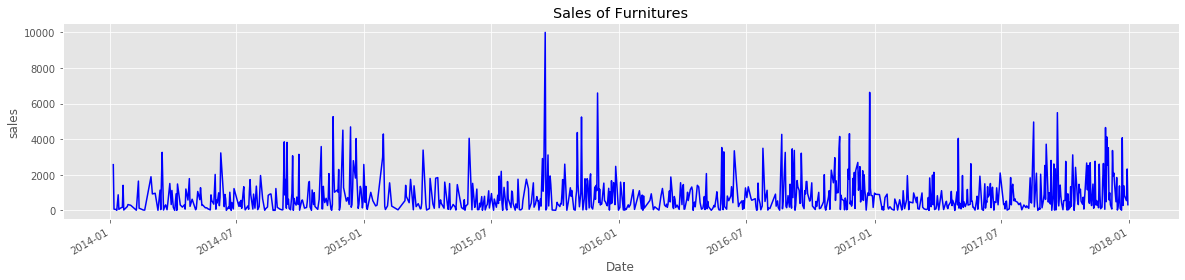

In [8]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furnitures")
plt.show()

In [9]:
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()
#df= avg_furniture_sales
#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

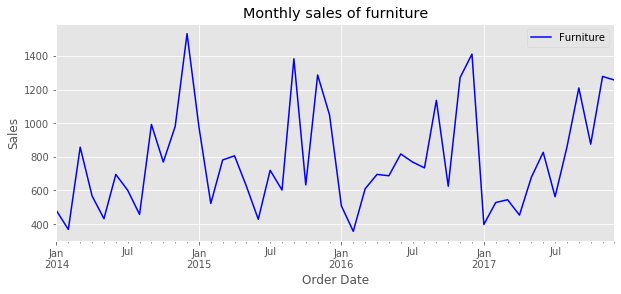

In [10]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

### Measure of prediction accuracy

In [11]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

## CNN

In [12]:
train, test = np.array(df[:-12]), np.array(df[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [13]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [14]:
dfcnn= np.array(df)
dfcnn= dfcnn.reshape(-1,1)
#Scale data
scaler = MinMaxScaler()
ts = scaler.fit_transform(dfcnn)

In [15]:
#Set the timestep
timestep = 12
X= []
Y=[]
raw_data=ts
for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)
#Set the trainset
X_train = X[:24,:,:]  
Y_train = Y[:24] 
#Set the testset
X_test = X[24:,:,:]  
Y_test= Y[24:]

In [16]:
#define model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(12, 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')


# fit model
cnn_model.fit(X_train, Y_train, epochs=200, verbose=1) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 24 samples
Epoch 1/200
24/24 [==============================] - 0s 14ms/sample - loss: 0.2504
Epoch 2/200
24/24 [==============================] - 0s 291us/sample - loss: 0.1902
Epoch 3/200
24/24 [==============================] - 0s 820us/sample - loss: 0.1509
Epoch 4/200
24/24 [==============================] - 0s 440us/sample - loss: 0.1203
Epoch 5/200
24/24 [==============================] - 0s 769us/sample - loss: 0.0947
Epoch 6/200
24/24 [==============================] - 0s 639us/sample - loss: 0.0776
Epoch 7/200
24/24 [==============================] - 0s 531us/sample - loss: 0.0765
Epoch 8/200
24/24 [==============================] - 0s 750us/sample - loss: 0.0886
Epoch 9/200
24/24 [==============================] - 0s 610us/sample - loss: 0.0927
Epoch 10/200
24/24 [==============================] - 0s 772us/sample - loss: 0.0850
Epoch 11/200
24/24 [==============================] - 0s 30

Epoch 93/200
24/24 [==============================] - 0s 641us/sample - loss: 1.1386e-04
Epoch 94/200
24/24 [==============================] - 0s 460us/sample - loss: 8.9281e-05
Epoch 95/200
24/24 [==============================] - 0s 468us/sample - loss: 7.0927e-05
Epoch 96/200
24/24 [==============================] - 0s 339us/sample - loss: 5.7046e-05
Epoch 97/200
24/24 [==============================] - 0s 340us/sample - loss: 4.5391e-05
Epoch 98/200
24/24 [==============================] - 0s 243us/sample - loss: 3.7451e-05
Epoch 99/200
24/24 [==============================] - 0s 347us/sample - loss: 2.8938e-05
Epoch 100/200
24/24 [==============================] - 0s 293us/sample - loss: 2.4685e-05
Epoch 101/200
24/24 [==============================] - 0s 363us/sample - loss: 2.2404e-05
Epoch 102/200
24/24 [==============================] - 0s 427us/sample - loss: 2.1360e-05
Epoch 103/200
24/24 [==============================] - 0s 263us/sample - loss: 1.9886e-05
Epoch 104/200
24/

Epoch 185/200
24/24 [==============================] - 0s 352us/sample - loss: 2.5626e-06
Epoch 186/200
24/24 [==============================] - 0s 250us/sample - loss: 4.0308e-06
Epoch 187/200
24/24 [==============================] - 0s 354us/sample - loss: 1.7315e-06
Epoch 188/200
24/24 [==============================] - 0s 296us/sample - loss: 1.0704e-08
Epoch 189/200
24/24 [==============================] - 0s 310us/sample - loss: 1.4292e-06
Epoch 190/200
24/24 [==============================] - 0s 499us/sample - loss: 2.7280e-06
Epoch 191/200
24/24 [==============================] - 0s 469us/sample - loss: 1.4998e-06
Epoch 192/200
24/24 [==============================] - 0s 966us/sample - loss: 5.7389e-08
Epoch 193/200
24/24 [==============================] - 0s 2ms/sample - loss: 6.3373e-07
Epoch 194/200
24/24 [==============================] - 0s 1ms/sample - loss: 1.7385e-06
Epoch 195/200
24/24 [==============================] - 0s 644us/sample - loss: 1.3371e-06
Epoch 196/200


In [17]:
# Validate data
preds = cnn_model.predict(X_test)
preds=np.array(preds)
preds=preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)


Y_test=np.asanyarray(Y_test)  
Y_test=Y_test.reshape(-1,1) 
Y_test = scaler.inverse_transform(Y_test)


Y_train=np.asanyarray(Y_train)  
Y_train=Y_train.reshape(-1,1) 
Y_train = scaler.inverse_transform(Y_train)

In [18]:
cnn= performance(Y_test,preds)
cnn_predict= preds.reshape((12,))
cnn

{'MSE': 38393.17, 'RMSE': 195.94, 'MAPE': 21.82}

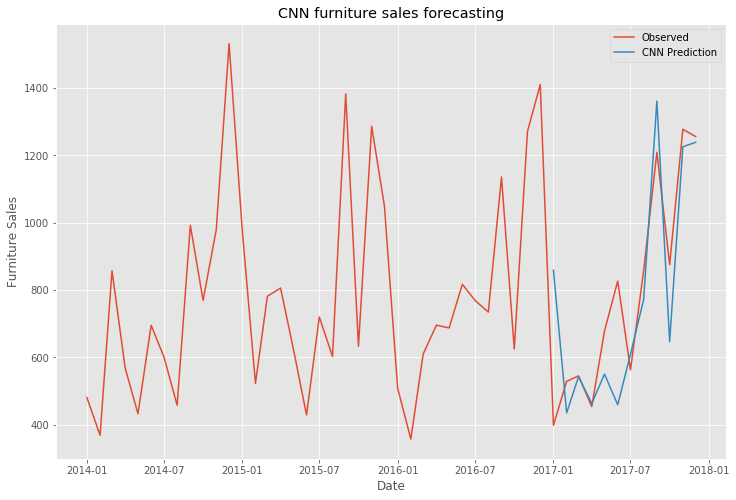

In [19]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,preds,label="CNN Prediction")
plt.title('CNN furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

#### Source: 
    
https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ 

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/


https://www.kaggle.com/fatmakursun/predict-sales-time-series-with-cnn